In [2]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [4]:
Z_DIM=64
BATCH_SIZE=128
DEVICE='cuda'
LR=0.00001
N_EPOCHS=200
DISPLAY_STEP=10

In [4]:
def display_imgs(imgs, size=(1, 28, 28)):
    img_unflat = imgs.detach().cpu().view(-1, *size)
    img_grid = make_grid(img_unflat[:25], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

# Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim=64, h_dim=128, img_dim=784):
        super(Generator, self).__init__()
        
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.layer(z_dim, h_dim),
            self.layer(h_dim, h_dim*2),
            self.layer(h_dim*2, h_dim*4),
            self.layer(h_dim*4, h_dim*8),
            nn.Linear(h_dim*8, img_dim),
            nn.Sigmoid()
        )
        
    @staticmethod
    def get_noise(n_samples, z_dim, device=DEVICE):
        return torch.randn(n_samples, z_dim, device=device)
        
    def forward(self, noise):
        return self.gen(noise)
    
    def get_imgs(self, n_imgs):
        noise = Generator.get_noise(n_imgs, self.z_dim)
        return self(noise)
    
    def layer(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.BatchNorm1d(out_dim),
            nn.ReLU(inplace=True),
        )

# Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, img_dim=784, h_dim=128):
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            self.layer(img_dim, h_dim*4),
            self.layer(h_dim*4, h_dim*2),
            self.layer(h_dim*2, h_dim),
            nn.Linear(h_dim, 1),
        )
        
    def forward(self, img):
        return self.disc(img)
        
    def layer(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

# Generator & Discriminator loss functions

In [7]:
def get_gen_loss(gen, disc, criterion, n_samples, z_dim, device):
    noise = Generator.get_noise(n_samples, z_dim, device)
    fake_imgs = gen(noise)
    pred = disc(fake_imgs)
    loss = criterion(pred, torch.ones_like(pred))
    
    return loss

In [8]:
def get_disc_loss(gen, disc, imgs_real, criterion, n_samples, z_dim, device):
    noise = Generator.get_noise(n_samples, z_dim, device)
    imgs_fake = gen(noise)
    pred_fake = disc(imgs_fake.detach())
    loss_fake = criterion(pred_fake, torch.zeros_like(pred_fake))
    pred_real = disc(imgs_real)
    loss_real = criterion(pred_real, torch.ones_like(pred_real))
    
    loss = (loss_fake + loss_real) / 2
    return loss

# Data Loading & Initialization

In [5]:
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [10]:
criterion = nn.BCEWithLogitsLoss()

gen = Generator(Z_DIM).to(DEVICE)
disc = Discriminator().to(DEVICE)
gen_opt = torch.optim.Adam(gen.parameters(), lr=LR)
disc_opt = torch.optim.Adam(disc.parameters(), lr=LR)

# Training

  0%|          | 0/200 [00:00<?, ?it/s]

After 0 epochs


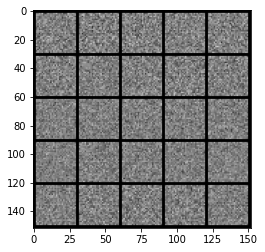

After 10 epochs


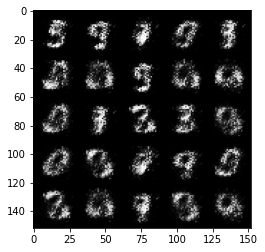

After 20 epochs


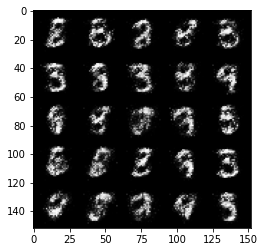

After 30 epochs


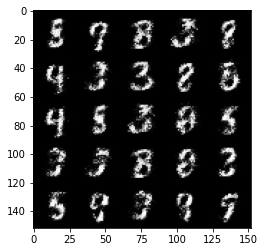

After 40 epochs


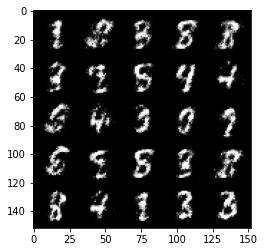

After 50 epochs


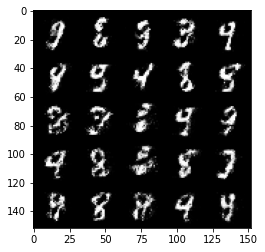

After 60 epochs


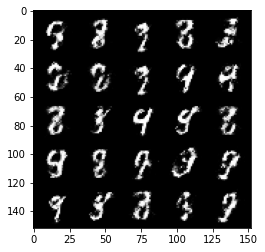

After 70 epochs


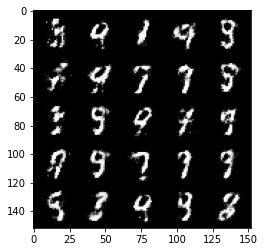

After 80 epochs


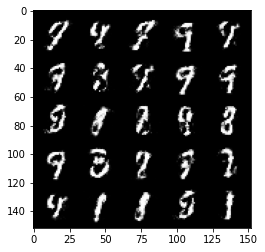

After 90 epochs


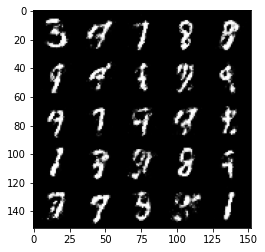

After 100 epochs


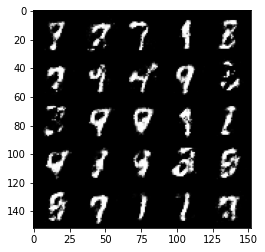

After 110 epochs


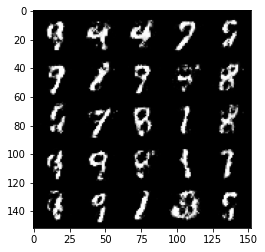

After 120 epochs


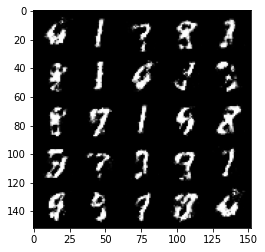

After 130 epochs


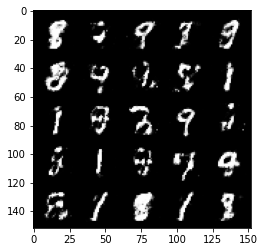

After 140 epochs


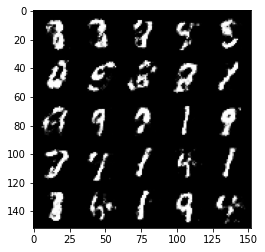

After 150 epochs


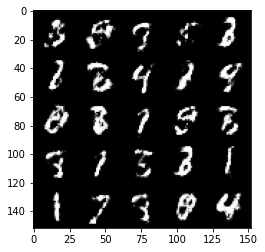

After 160 epochs


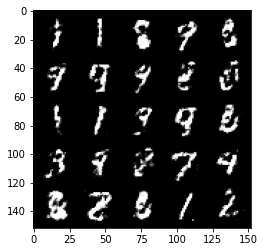

After 170 epochs


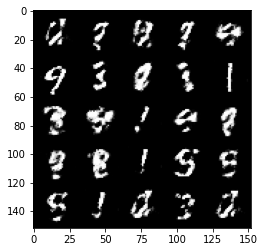

After 180 epochs


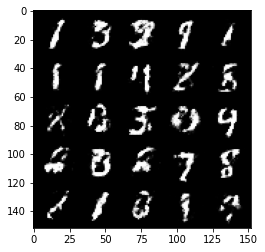

After 190 epochs


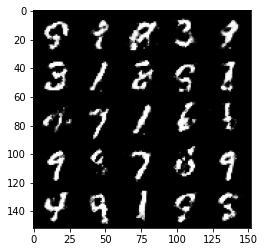

In [11]:
tqdm_obj = tqdm(range(0, N_EPOCHS))
no_of_batches = len(dataloader)

for epoch in tqdm_obj:
    if epoch % DISPLAY_STEP == 0:
        print(f'After {epoch} epochs')
        imgs = gen.get_imgs(25)
        display_imgs(imgs)

    for i, (imgs, _) in enumerate(dataloader, 0):
        tqdm_obj.set_postfix({ 'Batch': f'{i}/{no_of_batches}' })
        cur_batch_size = len(imgs)
        imgs = imgs.view(cur_batch_size, 784).to(DEVICE)

        # Discriminator training
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, imgs, criterion, cur_batch_size, Z_DIM, DEVICE)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        # Generator training
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, Z_DIM, DEVICE)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()